# systematics with the Asimov dataset

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/wbr/analysis


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/original/'
selections = [
              'emu', 
              'mumu',  'mutau',  'mu4j',
              'ee',  'etau', 'e4j'
             ]
n_selection = len(selections)
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'trailing_lepton_pt', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jets'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jets']
                  )

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, targets)

In [3]:
# generate Asimov dataset
toy_data = dict()
for selection in selections:
    toy_data[selection] = dict()
    sdata = fit_data.get_selection_data(selection)
    for category, bdata in sdata.items():
        
        templates = bdata['templates']
        # signal component
        toy_data[selection][category] = np.zeros(bdata['bins'].size - 1)
        for dataset, template in templates.items():
            if dataset in['ttbar', 't', 'wjets']: 
                signal_template = pd.DataFrame.from_items((dm, t['val']) for dm, t in template.items())
                signal = fh.signal_mixture_model(beta_init, br_tau, signal_template, sample=False, single_w=(dataset == 'wjets'))
                toy_data[selection][category] += signal
            elif dataset != 'data':
                toy_data[selection][category] += template['val']

No handles with labels found to put in legend.
No handles with labels found to put in legend.


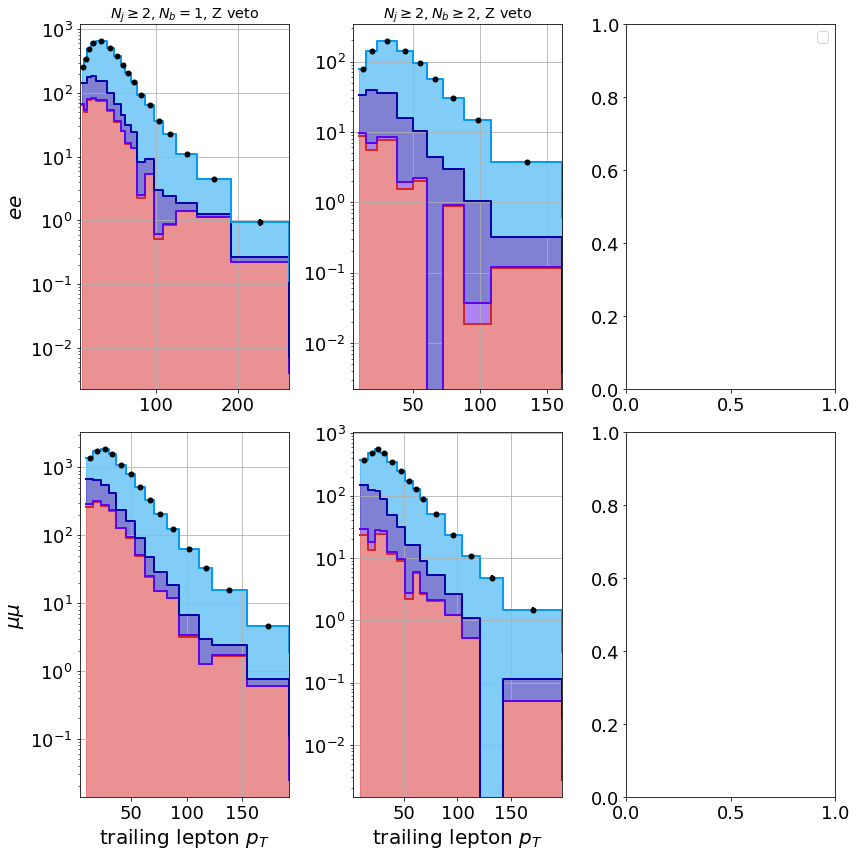

In [4]:
# visualize toy data (ee, mumu)
#fig, axes = plt.subplots(len(pt.categories), len(selections), figsize=(24, 12), facecolor='white')
fig, axes = plt.subplots(2, 3, figsize=(12, 12), facecolor='white')
for i, selection in enumerate(['ee', 'mumu']):
    for j, (category, template_data) in enumerate(fit_data.get_selection_data(selection).items()):
        ax = axes[i][j]
        if i == 0: 
            ax.set_title(pt.categories[category].label)
        
        if i == 1:
            ax.set_xlabel('trailing lepton $p_{T}$')
            
        if j == 0:
            ax.set_ylabel(plot_labels[selection][1])
            
        # get and plot the data 
        templates = template_data['templates']
        bins = template_data['bins'][:-1]
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x  = bins + dx/2            

        data = toy_data[selection][category]
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        h_bg      = np.zeros(data.shape)
        h_twotau  = np.zeros(data.shape)
        h_onetau  = np.zeros(data.shape)
        h_nominal = np.zeros(data.shape)
        for dataset, template in templates.items():
            if dataset in ['ttbar', 't']:
                signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
                h_twotau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_twotau'])
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_onetau'])
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template)
            elif dataset == 'wjets':
                signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=np.array([0, 0, 1, 1, 1, 0]), single_w=True)
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template, single_w=True)
            elif dataset != 'data':
                h_bg += template['val']
                
        h_nominal += h_bg
        h_twotau += h_bg
        h_onetau += h_twotau
        
        ax.plot(bins, h_bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, color='C3', step='post', alpha=0.5, label='bg')
        
        ax.plot(bins, h_twotau/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, h_twotau/dx, color='xkcd:blue violet', step='post', alpha=0.5, label=r'2 $\tau$' )
        ax.plot(bins, h_onetau/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_twotau/dx, h_onetau/dx, color='xkcd:royal blue', step='post', alpha=0.5, label=r'1 $\tau$')
        ax.plot(bins, h_nominal/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2., label='_nolegend')
        ax.fill_between(bins, h_onetau/dx, h_nominal/dx, color='xkcd:azure', step='post', alpha=0.5, label=r'0 $\tau$')
    
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        #ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        ax.grid()
        
    axes[0][-1].legend(fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example_ll.pdf')
plt.show()

No handles with labels found to put in legend.


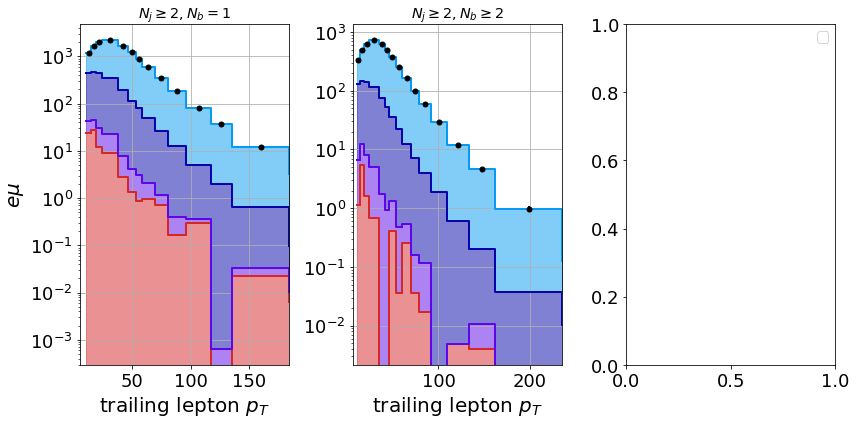

In [5]:
# visualize toy data (emu)
#fig, axes = plt.subplots(len(pt.categories), len(selections), figsize=(24, 12), facecolor='white')
fig, axes = plt.subplots(1, 3, figsize=(12, 6), facecolor='white')

selection = 'emu'
for j, (category, template_data) in enumerate(fit_data.get_selection_data(selection).items()):
    ax = axes[j]
    ax.set_title(pt.categories[category].label)
    ax.set_xlabel('trailing lepton $p_{T}$')
            
    if j == 0:
        ax.set_ylabel(plot_labels[selection][1])

    # get and plot the data 
    templates = template_data['templates']
    bins = template_data['bins'][:-1]
    dx = (bins[1:] - bins[:-1])
    dx = np.append(dx, dx[-1]) 
    x  = bins + dx/2            

    data = toy_data[selection][category]
    ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)

    h_bg      = np.zeros(data.shape)
    h_twotau  = np.zeros(data.shape)
    h_onetau  = np.zeros(data.shape)
    h_nominal = np.zeros(data.shape)
    for dataset, template in templates.items():
        if dataset in ['ttbar', 't']:
            signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
            h_twotau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_twotau'])
            h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_onetau'])
            h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template)
        elif dataset == 'wjets':
            signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
            h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=np.array([0, 0, 1, 1, 1, 0]), single_w=True)
            h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template, single_w=True)
        elif dataset != 'data':
            h_bg += template['val']

    h_nominal += h_bg
    h_twotau += h_bg
    h_onetau += h_twotau

    ax.plot(bins, h_bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2., label='_nolegend_')
    ax.fill_between(bins, h_bg/dx, color='C3', step='post', alpha=0.5, label='bg')

    ax.plot(bins, h_twotau/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2., label='_nolegend_')
    ax.fill_between(bins, h_bg/dx, h_twotau/dx, color='xkcd:blue violet', step='post', alpha=0.5, label=r'2 $\tau$' )
    ax.plot(bins, h_onetau/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2., label='_nolegend_')
    ax.fill_between(bins, h_twotau/dx, h_onetau/dx, color='xkcd:royal blue', step='post', alpha=0.5, label=r'1 $\tau$')
    ax.plot(bins, h_nominal/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2., label='_nolegend')
    ax.fill_between(bins, h_onetau/dx, h_nominal/dx, color='xkcd:azure', step='post', alpha=0.5, label=r'0 $\tau$')

    xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
    ax.set_xlim(xmin, xmax)
    #ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
    ax.set_yscale('log')
    ax.grid()

axes[-1].legend(fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example_emu.pdf')
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


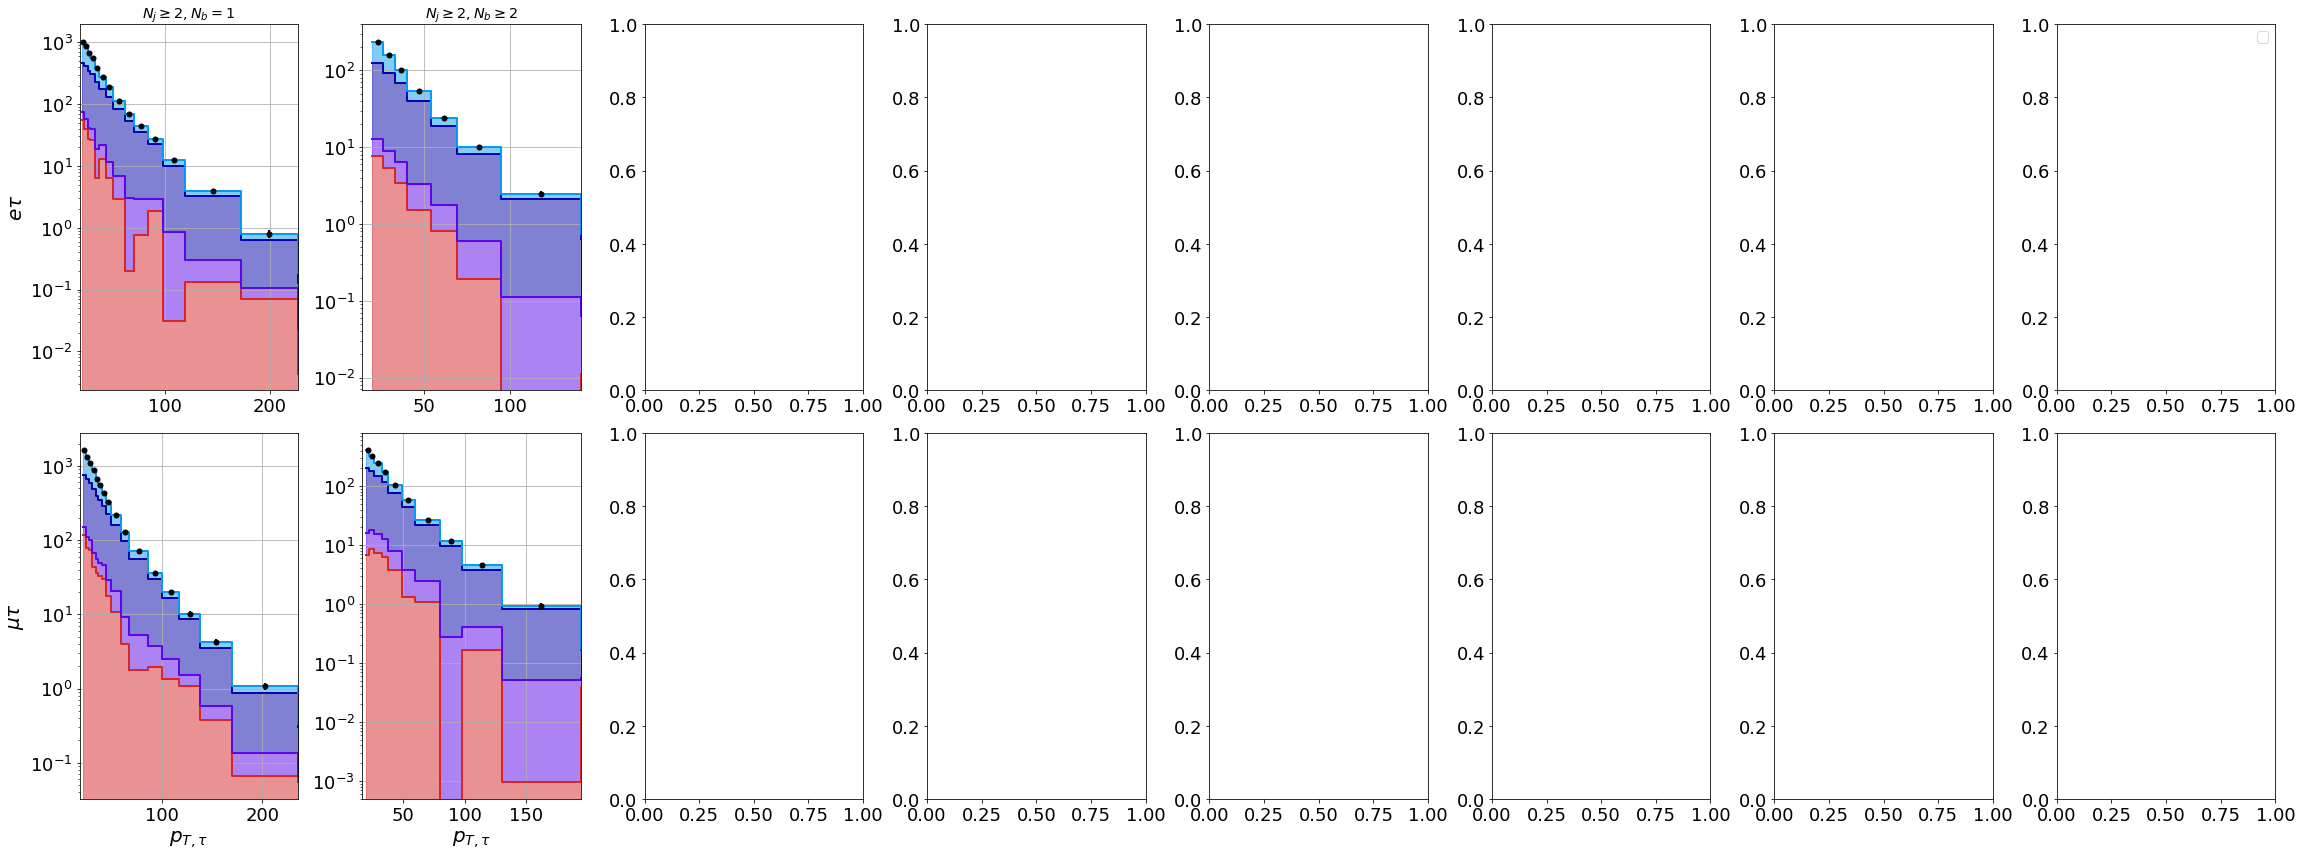

In [6]:
# visualize toy data (mutau, etau)
#fig, axes = plt.subplots(len(pt.categories), len(selections), figsize=(24, 12), facecolor='white')
fig, axes = plt.subplots(2, 8, figsize=(32, 12), facecolor='white')
for i, selection in enumerate(['etau', 'mutau']):
    for j, (category, template_data) in enumerate(fit_data.get_selection_data(selection).items()):
        ax = axes[i][j]
        if i == 0: 
            ax.set_title(pt.categories[category].label)
        
        if i == 1:
            ax.set_xlabel(r'$p_{T, \tau}$')
            
        if j == 0:
            ax.set_ylabel(plot_labels[selection][1])
            
        # get and plot the data 
        templates = template_data['templates']
        bins = template_data['bins'][:-1]
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x  = bins + dx/2            

        data = toy_data[selection][category]
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        h_bg      = np.zeros(data.shape)
        h_twotau  = np.zeros(data.shape)
        h_onetau  = np.zeros(data.shape)
        h_nominal = np.zeros(data.shape)
        for dataset, template in templates.items():
            if dataset in ['ttbar', 't']:
                signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
                h_twotau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_twotau'])
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_onetau'])
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template)
            elif dataset == 'wjets':
                signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=np.array([0, 0, 1, 1, 1, 0]), single_w=True)
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template, single_w=True)
            elif dataset != 'data':
                h_bg += template['val']
                
        h_nominal += h_bg
        h_twotau += h_bg
        h_onetau += h_twotau
        
        ax.plot(bins, h_bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, color='C3', step='post', alpha=0.5, label='bg')
        
        ax.plot(bins, h_twotau/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, h_twotau/dx, color='xkcd:blue violet', step='post', alpha=0.5, label=r'2 $\tau$' )
        ax.plot(bins, h_onetau/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_twotau/dx, h_onetau/dx, color='xkcd:royal blue', step='post', alpha=0.5, label=r'1 $\tau$')
        ax.plot(bins, h_nominal/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2., label='_nolegend')
        ax.fill_between(bins, h_onetau/dx, h_nominal/dx, color='xkcd:azure', step='post', alpha=0.5, label=r'0 $\tau$')
    
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        #ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        ax.grid()
        
    axes[0][-1].legend(fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example_ltau.pdf')
plt.show()

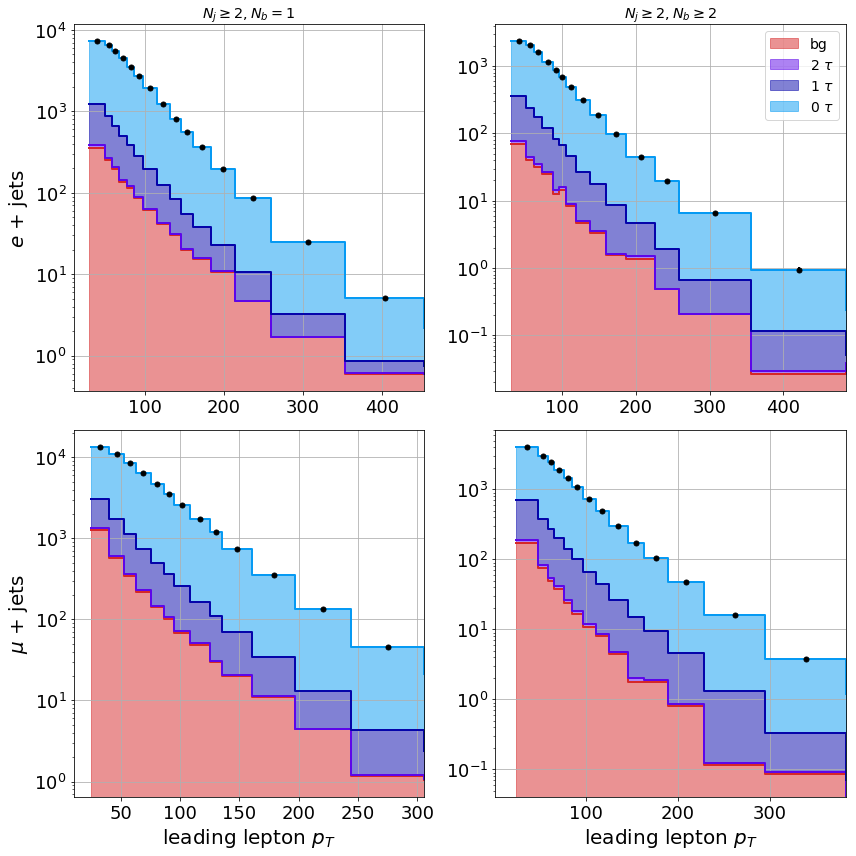

In [7]:
# visualize toy data (e+jet, mu+jet)
#fig, axes = plt.subplots(len(pt.categories), len(selections), figsize=(24, 12), facecolor='white')
fig, axes = plt.subplots(2, 2, figsize=(12, 12), facecolor='white')
for i, selection in enumerate(['e4j', 'mu4j']):
    for j, (category, template_data) in enumerate(fit_data.get_selection_data(selection).items()):
        ax = axes[i][j]
        if i == 0: 
            ax.set_title(pt.categories[category].label)
        
        if i == 1:
            ax.set_xlabel('leading lepton $p_{T}$')
            
        if j == 0:
            ax.set_ylabel(plot_labels[selection][1])
            
        # get and plot the data 
        templates = template_data['templates']
        bins = template_data['bins'][:-1]
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x  = bins + dx/2            

        data = toy_data[selection][category]
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        h_bg      = np.zeros(data.shape)
        h_twotau  = np.zeros(data.shape)
        h_onetau  = np.zeros(data.shape)
        h_nominal = np.zeros(data.shape)
        for dataset, template in templates.items():
            if dataset in ['ttbar', 't']:
                signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
                h_twotau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_twotau'])
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_onetau'])
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template)
            elif dataset == 'wjets':
                signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=np.array([0, 0, 1, 1, 1, 0]), single_w=True)
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template, single_w=True)
            elif dataset != 'data':
                h_bg += template['val']
                
        h_nominal += h_bg
        h_twotau += h_bg
        h_onetau += h_twotau
        
        ax.plot(bins, h_bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, color='C3', step='post', alpha=0.5, label='bg')
        
        ax.plot(bins, h_twotau/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, h_twotau/dx, color='xkcd:blue violet', step='post', alpha=0.5, label=r'2 $\tau$' )
        ax.plot(bins, h_onetau/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_twotau/dx, h_onetau/dx, color='xkcd:royal blue', step='post', alpha=0.5, label=r'1 $\tau$')
        ax.plot(bins, h_nominal/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2., label='_nolegend')
        ax.fill_between(bins, h_onetau/dx, h_nominal/dx, color='xkcd:azure', step='post', alpha=0.5, label=r'0 $\tau$')
    
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        #ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        ax.grid()
        
    axes[0][-1].legend(fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example_ljets.pdf')
plt.show()

In [8]:
# nominal case
params_init = fit_data.get_params_init()
cost_type = 'poisson'
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type, no_shape=False)
stderr, corr = fh.calculate_covariance(fobj, params_init)

In [9]:
# plot errors
params = fit_data._parameters
p_labels = list(params.index.values)
params_init = params.val_init.values

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', len(p_labels))
pd.set_option('display.max_rows', len(p_labels))

pct_err = pd.DataFrame(np.array([100*params_init[:4], 100*stderr[:4], 100*stderr[:4]/params_init[:4]]).T, 
                       index=p_labels[:4], 
                       columns=['params_init', 'stderr', 'stderr (%)']
                      )
pct_err

,params_init,stderr,stderr (%)
beta_e,10.800,0.032,0.298
beta_mu,10.800,0.032,0.295
beta_tau,10.800,0.078,0.725
beta_h,67.600,0.090,0.133


In [10]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pct_err = pd.DataFrame(np.array([params_init, 100*params.err_init, 100*stderr, params.err_init/stderr]).T, 
                       index=p_labels, 
                       columns=['params_init', 'stderr_pre (%)', 'stderr_post (%)', 'constraint']
                      )
pct_err[4:]

,params_init,stderr_pre (%),stderr_post (%),constraint
br_tau_e,0.178,0.040,0.040,1.002
br_tau_mu,0.174,0.040,0.040,1.004
br_tau_h,0.648,0.100,0.100,1.003
lumi,1.000,2.500,2.028,1.233
xs_zjets,1.000,10.000,3.343,2.992
xs_diboson,1.000,10.000,9.990,1.001
xs_ttbar,1.000,5.000,2.089,2.394
xs_t,1.000,10.000,6.077,1.646
xs_wjets,1.000,5.000,4.034,1.239


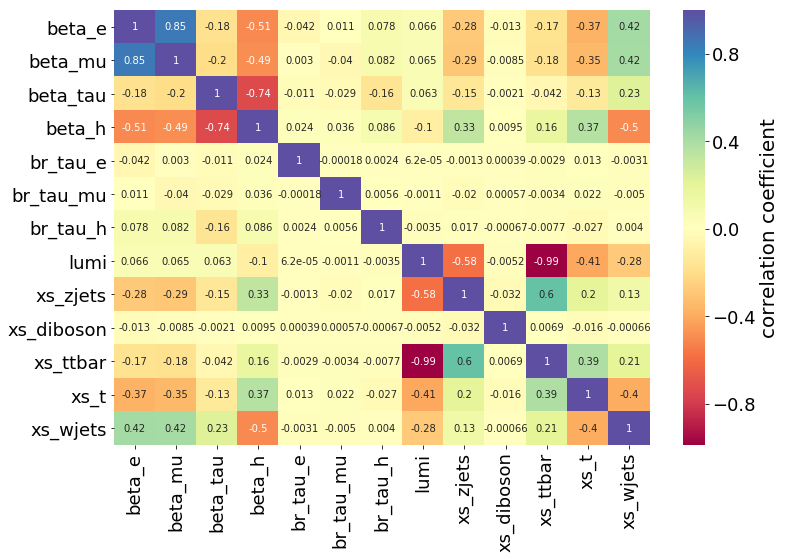

In [11]:
df_corr = pd.DataFrame(corr, columns=p_labels, index=p_labels)
df_corr.to_latex('data/cov_table_full.tex')
df_corr.to_csv('data/cov_table_full.csv')

import seaborn as sns
#fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(32, 24))
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(12, 8))
sns.heatmap(df_corr, cmap='Spectral', annot=True, ax=ax, cbar_kws={'label': r'correlation coefficient'})
plt.show()

### Estimating individual contributions

If we make the assumption that the uncertainties sum in quadrature (which they should really given all of the correlations), we can write the total uncertainty as,

$$
\sigma_{total}^{2} = \sigma_{stat}^{2} + \sum_{i}\sigma_{i,syst}^{2}
$$

From this we can write evaluate the contribution from a single systematic source as,

$$
\sigma_{i,syst}^{2} = \sigma_{total}^{2} - \sigma_{stat}^{2} - \sum_{j\neq i}\sigma_{j,syst}^{2}
$$


In [12]:
# n-1 uncertainties
from tqdm import tqdm_notebook, trange
from multiprocessing import Pool

def reduced_objective(p, mask, p_init):
    masked_p = p_init.copy()
    masked_p[mask] = p
    return fit_data.objective(masked_p, data=toy_data, cost_type=cost_type)

# stat only
mask = np.ones(len(params_init)).astype(bool)
mask[4:] = False
fobj = partial(reduced_objective, mask=mask, p_init=params_init)
err_stat, _ = fh.calculate_covariance(fobj, params_init[:4])
err_stat = np.concatenate([err_stat, np.zeros(params_init[4:].size)])

# n-1 systematics
pool = Pool(processes=12)
results = []
for i in range(4, len(params_init)):
    mask = np.ones(len(params_init)).astype(bool)
    mask[i] = False
    fobj = partial(reduced_objective, mask=mask, p_init=params_init)
    res = pool.apply_async(fh.calculate_covariance, args=(fobj, np.delete(params_init, i)))
    results.append(res)
    
pool.close()
pool.join()

output = [r.get() for r in results]

[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]
beta_e 0.10800000000000001 0.0
beta_mu 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
br_tau_e 0.1783 0.0
br_tau_mu 0.1741 0.0
br_tau_h 0.6476 0.0
lumi 1.0 0.0
xs_zjets 1.0 0.0
xs_diboson 1.0 0.0
xs_ttbar 1.0 0.0
xs_t 1.0 0.0
xs_wjets 1.0 0.0
[0.11  0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]
beta_e 0.10959999999999984 1.0973936899860408
beta_mu 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
br_tau_e 0.1783 0.0
br_tau_mu 0.1741 0.0
br_tau_h 0.6476 0.0
lumi 1.0 0.0
xs_zjets 1.0 0.0
xs_diboson 1.0 0.0
xs_ttbar 1.0 0.0
xs_t 1.0 0.0
xs_wjets 1.0 0.0
[0.108 0.11  0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]
beta_e 0.10800000000000001 0.0
beta_mu 0.10959999999999984 1.0973936899860408
beta_tau 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
br_tau_e 0.1783 0.0
br_tau_mu 0.1741 0.0
br_

[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ][0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ][0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ][0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]

[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ][0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ][0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ][0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ][0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]

beta_e 0.10800000000000001 0.0



beta_e 0.10800000000000001 0.0


beta_mu 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
beta_mu 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
beta_tau 0.108000

br_tau_mu 0.1741 0.0
beta_tau 0.10800000000000001 0.0
br_tau_e 0.1783 0.0
br_tau_mu 0.1741 0.0
br_tau_mu 0.1741 0.0
br_tau_e 0.1783 0.0
br_tau_mu 0.1741 0.0
beta_h 0.6759999999999999 0.0
br_tau_h 0.6476 0.0
beta_tau 0.10800000000000001 0.0
br_tau_h 0.6476 0.0
br_tau_h 0.6476 0.0
lumi 1.0 0.0
br_tau_h 0.6476 0.0
br_tau_h 0.6476 0.0
br_tau_mu 0.1741 0.0
br_tau_e 0.1783 0.0
lumi 1.0 0.0
br_tau_mu 0.1741 0.0
lumi 1.0 0.0
lumi 1.0 0.0
beta_h 0.6759999999999999 0.0
xs_zjets 1.0 0.0
lumi 1.0 0.0
xs_zjets 1.0 0.0
xs_wjets 1.0 0.0
beta_tau 0.10800000000000001 0.0
br_tau_e 0.1783 0.0
br_tau_h 0.6476 0.0
xs_zjets 1.0 0.0
xs_zjets 1.0 0.0
xs_diboson 1.0 0.0
beta_h 0.6759999999999999 0.0
[0.108 0.11  0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]xs_zjets 1.0 0.0
xs_diboson 1.0 0.0
br_tau_mu 0.1741 0.0
lumi 1.0 0.0
xs_diboson 1.0 0.0
xs_diboson 1.0 0.0
br_tau_e 0.1783 0.0
xs_ttbar 1.0 0.0

xs_ttbar 1.0 0.0
xs_diboson 1.0 0.0
br_tau_h 0.6476 0.0
xs_zjets 1.0 0.0
xs_ttbar 1.0 0.0
xs_

 1.   ]xs_zjets 1.0 0.0

lumi 1.0 0.0

xs_zjets 1.0 0.0
beta_e 0.10800000000000001 0.0

[0.108 0.108 0.108 0.676 0.18  0.174 0.648 1.    1.    1.    1.    1.
 1.   ]xs_diboson 1.0 0.0
beta_e 0.10800000000000001 0.0
xs_zjets 1.0 0.0
[0.108 0.108 0.108 0.676 0.18  0.174 0.648 1.    1.    1.    1.    1.
 1.   ]beta_mu 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
xs_diboson 1.0 0.0
beta_e 0.10800000000000001 0.0
xs_ttbar 1.0 0.0
beta_mu 0.10800000000000001 0.0

xs_diboson 1.0 0.0

beta_tau 0.10800000000000001 0.0
beta_mu 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0
beta_mu 0.10800000000000001 0.0
xs_ttbar 1.0 0.0
xs_t 1.0 0.0
beta_e 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
beta_e 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
xs_t 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_wjets 1.0 0.0
br_tau_e 0.1798999999999998 7.999999999998237
beta_mu 0.10800000000000001 0.0
xs_ttbar 1.0 0.0
beta_mu 0.10800000000000001 0.0
xs_

beta_h 0.6759999999999999 0.0
br_tau_e 0.1783 0.0
xs_diboson 1.0 0.0
xs_zjets 1.0 0.0
beta_tau 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.002 1.    1.    1.    1.
 1.   ]beta_mu 0.10800000000000001 0.0
br_tau_mu 0.1741 0.0
xs_diboson 1.0 0.0
br_tau_e 0.1783 0.0
br_tau_h 0.6476 0.0
beta_h 0.6759999999999999 0.0
xs_ttbar 1.0 0.0
br_tau_e 0.1783 0.0

br_tau_h 0.6491999999999998 1.279999999999718
beta_tau 0.10800000000000001 0.0
xs_ttbar 1.0 0.0
br_tau_mu 0.1741 0.0
xs_t 1.0 0.0
br_tau_e 0.1783 0.0
br_tau_mu 0.17569999999999983 7.999999999998237
beta_e 0.10800000000000001 0.0
lumi 1.0 0.0
lumi 1.0015999999999998 0.0020479999999995484
br_tau_mu 0.1741 0.0
xs_t 1.0 0.0
beta_h 0.6759999999999999 0.0
beta_mu 0.10800000000000001 0.0
br_tau_h 0.6491999999999998 1.279999999999718
br_tau_h 0.6476 0.0
xs_wjets 1.0 0.0
xs_zjets 1.0 0.0
br_tau_e 0.1783 0.0
br_tau_h 0.6491999999999998 1.279999999999718
xs_wjets 1.0 0.0
xs_zjets 1.0 0.0
lumi 1.0 0

xs_ttbar 1.0 0.0
xs_ttbar 1.0 0.0
xs_wjets 1.0 0.0
br_tau_mu 0.1741 0.0

xs_diboson 1.0 0.0
lumi 1.0 0.0
xs_t 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_diboson 1.0 0.0
xs_ttbar 1.0 0.0
beta_e 0.10800000000000001 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.002 1.
 1.   ]br_tau_h 0.6476 0.0
xs_t 1.0 0.0
xs_wjets 1.0 0.0
xs_zjets 1.0 0.0
beta_h 0.6759999999999999 0.0
xs_t 1.0 0.0
xs_ttbar 1.0 0.0
beta_mu 0.10800000000000001 0.0
xs_wjets 1.0 0.0

lumi 1.0 0.0
xs_diboson 1.0015999999999998 0.00012799999999997178
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.002 1.    1.
 1.   ]br_tau_e 0.1783 0.0
xs_wjets 1.0 0.0
xs_t 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_zjets 1.0 0.0
beta_e 0.10800000000000001 0.0

br_tau_mu 0.1741 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.002 1.
 1.   ][0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.002 1.    1.
 1.   ]xs_wjets 1.0 0.0
xs_ttbar 1.0 0.0
xs_diboson 1.0015999999999998 0.000127999999


br_tau_mu 0.1741 0.0
xs_wjets 1.0 0.0
xs_zjets 1.0 0.0
beta_mu 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.002]beta_e 0.10800000000000001 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.002]br_tau_h 0.6476 0.0
beta_h 0.6759999999999999 0.0
beta_tau 0.10800000000000001 0.0

xs_diboson 1.0 0.0
beta_mu 0.10800000000000001 0.0

lumi 1.0 0.0
beta_mu 0.10800000000000001 0.0
lumi 1.0 0.0
br_tau_e 0.1783 0.0
beta_e 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
xs_ttbar 1.0 0.0
beta_e 0.10800000000000001 0.0
xs_zjets 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_zjets 1.0 0.0
beta_tau 0.10800000000000001 0.0
beta_mu 0.10800000000000001 0.0
br_tau_e 0.1783 0.0
br_tau_mu 0.1741 0.0
xs_t 1.0015999999999998 0.00012799999999997178
beta_mu 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
xs_diboson 1.0 0.0
beta_h 0.6759999999999999 0.0
beta_tau 

br_tau_mu 0.1741 0.0
beta_tau 0.10800000000000001 0.0
br_tau_mu 0.1741 0.0
xs_ttbar 1.0 0.0
br_tau_e 0.1783 0.0
br_tau_mu 0.1741 0.0
xs_wjets 1.0 0.0
br_tau_h 0.6476 0.0
beta_h 0.6759999999999999 0.0
br_tau_h 0.6476 0.0
beta_tau 0.10800000000000001 0.0
xs_t 1.0 0.0
xs_t 1.0 0.0
br_tau_mu 0.1741 0.0
br_tau_h 0.6476 0.0
br_tau_e 0.1783 0.0
lumi 1.0 0.0
xs_wjets 1.0 0.0
lumi 1.0 0.0
beta_h 0.6759999999999999 0.0
[0.11  0.11  0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]br_tau_h 0.6476 0.0
xs_wjets 1.0 0.0
lumi 1.0 0.0
xs_zjets 1.0 0.0

br_tau_e 0.1783 0.0
xs_zjets 1.0 0.0
lumi 1.0 0.0
br_tau_mu 0.1741 0.0
[0.11  0.11  0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]beta_e 0.10959999999999984 1.0973936899860408
[0.11  0.11  0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]xs_zjets 1.0 0.0
xs_diboson 1.0 0.0
xs_diboson 1.0 0.0
xs_zjets 1.0 0.0
br_tau_h 0.6476 0.0
xs_diboson 1.0 0.0
br_tau_mu 0.1741 0.0

xs_ttbar 1.0 0.0

xs_ttbar 1.0 0.0
xs_

 1.   ]xs_t 1.0 0.0
beta_h 0.6775999999999998 0.02801022373165589
xs_t 1.0 0.0
xs_diboson 1.0 0.0
[0.11  0.108 0.108 0.676 0.18  0.174 0.648 1.    1.    1.    1.    1.
 1.   ]beta_e 0.10959999999999984 1.0973936899860408
xs_ttbar 1.0 0.0
xs_wjets 1.0 0.0
xs_diboson 1.0 0.0
br_tau_e 0.1783 0.0
xs_ttbar 1.0 0.0
xs_wjets 1.0 0.0


xs_t 1.0 0.0
beta_mu 0.10800000000000001 0.0
br_tau_mu 0.1741 0.0
xs_ttbar 1.0 0.0
[0.11  0.108 0.108 0.676 0.18  0.174 0.648 1.    1.    1.    1.    1.
 1.   ]beta_e 0.10959999999999984 1.0973936899860408
xs_t 1.0 0.0
[0.11  0.108 0.108 0.676 0.18  0.174 0.648 1.    1.    1.    1.    1.
 1.   ]beta_e 0.10959999999999984 1.0973936899860408
xs_wjets 1.0 0.0
beta_tau 0.10800000000000001 0.0
br_tau_h 0.6476 0.0
xs_t 1.0 0.0
xs_wjets 1.0 0.0

beta_mu 0.10800000000000001 0.0

beta_h 0.6775999999999998 0.02801022373165589
lumi 1.0 0.0
beta_mu 0.10800000000000001 0.0
[0.11  0.108 0.108 0.678 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]beta_e 0.10959999999999984




xs_diboson 1.0 0.0
br_tau_h 0.6476 0.0
[0.11  0.108 0.108 0.676 0.178 0.176 0.648 1.    1.    1.    1.    1.
 1.   ]beta_tau 0.10800000000000001 0.0
[0.11  0.108 0.108 0.676 0.178 0.174 0.648 1.002 1.    1.    1.    1.
 1.   ]beta_e 0.10959999999999984 1.0973936899860408
beta_mu 0.10800000000000001 0.0
xs_ttbar 1.0 0.0
beta_e 0.10959999999999984 1.0973936899860408

lumi 1.0 0.0

beta_h 0.6759999999999999 0.0
beta_tau 0.10800000000000001 0.0
beta_mu 0.10800000000000001 0.0
xs_t 1.0 0.0
xs_zjets 1.0 0.0
beta_e 0.10959999999999984 1.0973936899860408
beta_e 0.10959999999999984 1.0973936899860408
beta_mu 0.10800000000000001 0.0
br_tau_e 0.1783 0.0
beta_h 0.6759999999999999 0.0
beta_tau 0.10800000000000001 0.0
xs_wjets 1.0 0.0
beta_mu 0.10800000000000001 0.0
xs_diboson 1.0 0.0
beta_mu 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0
br_tau_mu 0.1741 0.0
br_tau_e 0.1783 0.0
beta_h 0.6759999999999999 0.0
beta_tau 0.10800000000000001 0.0
beta_e 0.10959999999999984 1.0973936899860408


beta_h 0.6759999999999999 0.0
br_tau_mu 0.1741 0.0
beta_tau 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0

beta_h 0.6759999999999999 0.0
lumi 1.0 0.0
beta_tau 0.10800000000000001 0.0
br_tau_h 0.6476 0.0
beta_h 0.6759999999999999 0.0
br_tau_e 0.1783 0.0
xs_zjets 1.0015999999999998 0.00012799999999997178
beta_h 0.6759999999999999 0.0
beta_h 0.6759999999999999 0.0
beta_h 0.6759999999999999 0.0
beta_e 0.10959999999999984 1.0973936899860408
br_tau_e 0.1783 0.0
br_tau_e 0.1783 0.0
br_tau_mu 0.1741 0.0
br_tau_e 0.1783 0.0
br_tau_e 0.1783 0.0
lumi 1.0015999999999998 0.0020479999999995484
xs_diboson 1.0 0.0
beta_mu 0.10800000000000001 0.0
br_tau_mu 0.1741 0.0
br_tau_e 0.1783 0.0
br_tau_mu 0.1741 0.0
br_tau_h 0.6476 0.0
xs_zjets 1.0 0.0
br_tau_mu 0.1741 0.0
xs_ttbar 1.0 0.0
beta_tau 0.10800000000000001 0.0
br_tau_mu 0.1741 0.0
br_tau_mu 0.1741 0.0
lumi 1.0 0.0
br_tau_h 0.6476 0.0
br_tau_h 0.6476 0.0
br_tau_h 0.6476 0.0
br_tau_h 0.6476 0.0
xs_diboson 1.0 0.0
lumi 1.0 0.0
xs_t 1.0 0.0
l

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



xs_t 1.0 0.0
beta_e 0.10800000000000001 0.0
br_tau_mu 0.1741 0.0
br_tau_h 0.6476 0.0
beta_h 0.6759999999999999 0.0
lumi 1.0 0.0
xs_ttbar 1.0 0.0
beta_h 0.6759999999999999 0.0
xs_wjets 1.0015999999999998 0.0005119999999998871
beta_mu 0.10800000000000001 0.0
br_tau_e 0.1783 0.0
br_tau_h 0.6476 0.0
xs_zjets 1.0 0.0
lumi 1.0 0.0
br_tau_e 0.1783 0.0
beta_tau 0.10959999999999984 1.0973936899860408
br_tau_mu 0.1741 0.0
[0.108 0.108 0.111 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]lumi 1.0 0.0
xs_diboson 1.0 0.0
xs_zjets 1.0 0.0
xs_t 1.0 0.0
br_tau_mu 0.1741 0.0
beta_h 0.6775999999999998 0.02801022373165589
br_tau_h 0.6476 0.0

xs_diboson 1.0 0.0
xs_zjets 1.0 0.0
xs_ttbar 1.0 0.0
xs_diboson 1.0 0.0
xs_wjets 1.0 0.0
br_tau_h 0.6476 0.0
br_tau_e 0.1783 0.0
beta_e 0.10800000000000001 0.0
lumi 1.0 0.0
xs_ttbar 1.0 0.0
xs_diboson 1.0 0.0
xs_t 1.0 0.0
xs_ttbar 1.0 0.0
lumi 1.0 0.0
br_tau_mu 0.1741 0.0
xs_zjets 1.0 0.0
xs_ttbar 1.0 0.0
beta_mu 0.10800000000000001 0.0
[0.108 0.108 0.11 

br_tau_mu 0.17569999999999983 7.999999999998237
[0.108 0.108 0.11  0.676 0.178 0.176 0.648 1.    1.    1.    1.    1.
 1.   ]beta_e 0.10800000000000001 0.0
xs_diboson 1.0 0.0
beta_mu 0.10800000000000001 0.0
br_tau_mu 0.1741 0.0
beta_h 0.6759999999999999 0.0
xs_ttbar 1.0 0.0
br_tau_h 0.6476 0.0
beta_mu 0.10800000000000001 0.0
br_tau_h 0.6476 0.0
xs_ttbar 1.0 0.0
beta_tau 0.10959999999999984 1.0973936899860408

br_tau_h 0.6476 0.0
br_tau_e 0.1798999999999998 7.999999999998237
xs_t 1.0 0.0
lumi 1.0 0.0
beta_tau 0.10959999999999984 1.0973936899860408
xs_t 1.0 0.0
beta_h 0.6759999999999999 0.0
lumi 1.0 0.0
lumi 1.0 0.0
beta_e 0.10800000000000001 0.0
br_tau_mu 0.1741 0.0
xs_wjets 1.0 0.0
xs_zjets 1.0 0.0
br_tau_e 0.1798999999999998 7.999999999998237
beta_h 0.6775999999999998 0.02801022373165589
xs_zjets 1.0 0.0
br_tau_h 0.6476 0.0
xs_zjets 1.0 0.0
beta_mu 0.10800000000000001 0.0
[0.108 0.108 0.11  0.676 0.178 0.176 0.648 1.    1.    1.    1.    1.
 1.   ]xs_diboson 1.0 0.0
xs_wjets 1.0 0.0
b

beta_tau 0.10959999999999984 1.0973936899860408
[0.108 0.108 0.11  0.676 0.178 0.174 0.648 1.    1.002 1.    1.    1.
 1.   ]br_tau_e 0.1783 0.0
br_tau_e 0.1783 0.0
br_tau_mu 0.1741 0.0
xs_zjets 1.0 0.0
beta_h 0.6759999999999999 0.0
xs_zjets 1.0 0.0
xs_t 1.0 0.0

br_tau_mu 0.1741 0.0
br_tau_h 0.6491999999999998 1.279999999999718
xs_diboson 1.0 0.0
xs_wjets 1.0 0.0
xs_diboson 1.0 0.0
br_tau_h 0.6491999999999998 1.279999999999718
beta_e 0.10800000000000001 0.0
lumi 1.0 0.0
beta_h 0.6759999999999999 0.0
xs_ttbar 1.0 0.0
beta_h 0.6759999999999999 0.0
xs_ttbar 1.0 0.0
xs_zjets 1.0 0.0
[0.108 0.108 0.11  0.676 0.178 0.174 0.648 1.    1.    1.002 1.    1.
 1.   ]xs_t 1.0 0.0
lumi 1.0 0.0
beta_mu 0.10800000000000001 0.0
br_tau_e 0.1783 0.0
xs_t 1.0 0.0

br_tau_mu 0.1741 0.0
br_tau_e 0.1783 0.0
xs_diboson 1.0 0.0
xs_zjets 1.0 0.0
br_tau_mu 0.1741 0.0
beta_tau 0.10959999999999984 1.0973936899860408
br_tau_h 0.6476 0.0
beta_e 0.10800000000000001 0.0
br_tau_mu 0.17569999999999983 7.999999999998237

xs_ttbar 1.0 0.0
lumi 1.0 0.0
br_tau_e 0.1783 0.0
br_tau_h 0.6476 0.0
xs_ttbar 1.0 0.0
xs_ttbar 1.0 0.0
xs_t 1.0 0.0
br_tau_mu 0.1741 0.0
xs_t 1.0 0.0
lumi 1.0 0.0
[0.108 0.108 0.11  0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.002
 1.   ]xs_t 1.0 0.0
xs_zjets 1.0 0.0
xs_t 1.0 0.0
xs_wjets 1.0 0.0
br_tau_mu 0.1741 0.0
xs_wjets 1.0 0.0
br_tau_h 0.6476 0.0
xs_diboson 1.0 0.0

xs_wjets 1.0 0.0
xs_wjets 1.0 0.0
br_tau_h 0.6476 0.0
xs_zjets 1.0 0.0
[0.108 0.108 0.11  0.676 0.178 0.174 0.648 1.    1.    1.    1.002 1.
 1.   ]lumi 1.0015999999999998 0.0020479999999995484
xs_ttbar 1.0015999999999998 0.0005119999999998871
[0.108 0.108 0.11  0.676 0.178 0.174 0.648 1.    1.    1.002 1.    1.
 1.   ][0.108 0.108 0.11  0.676 0.178 0.174 0.648 1.    1.    1.    1.002 1.
 1.   ]beta_e 0.10800000000000001 0.0
lumi 1.0 0.0
xs_diboson 1.0015999999999998 0.00012799999999997178
[0.108 0.108 0.11  0.676 0.178 0.174 0.648 1.    1.    1.002 1.    1.
 1.   ]
xs_t 1.0 0.0
xs_zjets 1.0 0.0


beta_mu 0.108

 1.002]


xs_t 1.0 0.0
xs_t 1.0015999999999998 0.00012799999999997178

xs_t 1.0 0.0
br_tau_mu 0.1741 0.0

beta_e 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
xs_wjets 1.0 0.0
xs_wjets 1.0 0.0
beta_e 0.10800000000000001 0.0
xs_wjets 1.0015999999999998 0.0005119999999998871
br_tau_h 0.6476 0.0
beta_e 0.10800000000000001 0.0
beta_mu 0.10800000000000001 0.0
beta_mu 0.10800000000000001 0.0
beta_mu 0.10800000000000001 0.0
[0.108 0.108 0.11  0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.002
 1.   ]beta_mu 0.10800000000000001 0.0
lumi 1.0 0.0
beta_mu 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0
beta_tau 0.10959999999999984 1.0973936899860408
[0.108 0.108 0.108 0.679 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]beta_tau 0.10959999999999984 1.0973936899860408
[0.108 0.108 0.108 0.679 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]xs_zjets 1.0 0.0
beta_tau 0.10959999999999984 1.0973936899860408
beta_tau 0.10959999999999984 1.097

 1.   ]beta_h 0.6775999999999998 0.02801022373165589
beta_h 0.6775999999999998 0.02801022373165589
br_tau_e 0.1798999999999998 7.999999999998237
xs_diboson 1.0 0.0
br_tau_mu 0.1741 0.0


beta_h 0.6775999999999998 0.02801022373165589

br_tau_mu 0.1741 0.0
br_tau_e 0.1783 0.0
br_tau_e 0.1783 0.0
xs_ttbar 1.0 0.0
br_tau_h 0.6476 0.0
br_tau_e 0.1798999999999998 7.999999999998237
beta_e 0.10800000000000001 0.0
br_tau_mu 0.17569999999999983 7.999999999998237
br_tau_h 0.6476 0.0
xs_t 1.0 0.0
br_tau_mu 0.17569999999999983 7.999999999998237
lumi 1.0 0.0
beta_e 0.10800000000000001 0.0
br_tau_mu 0.1741 0.0
beta_mu 0.10800000000000001 0.0
br_tau_h 0.6476 0.0
lumi 1.0 0.0
beta_mu 0.10800000000000001 0.0
xs_wjets 1.0 0.0
br_tau_h 0.6476 0.0
xs_zjets 1.0 0.0
lumi 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_zjets 1.0 0.0
beta_e 0.10800000000000001 0.0
br_tau_h 0.6476 0.0
[0.108 0.108 0.108 0.678 0.178 0.174 0.649 1.    1.    1.    1.    1.
 1.   ]beta_h 0.6775999999999998 0.02801022373165589
xs_zjets 

br_tau_e 0.1783 0.0
br_tau_mu 0.1741 0.0
beta_tau 0.10800000000000001 0.0
xs_zjets 1.0 0.0
xs_zjets 1.0 0.0
xs_ttbar 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_wjets 1.0 0.0
br_tau_mu 0.1741 0.0
beta_h 0.6775999999999998 0.02801022373165589
[0.108 0.108 0.108 0.678 0.178 0.174 0.648 1.    1.002 1.    1.    1.
 1.   ]br_tau_h 0.6491999999999998 1.279999999999718
xs_diboson 1.0 0.0
xs_diboson 1.0 0.0
xs_t 1.0 0.0
beta_h 0.6775999999999998 0.02801022373165589
br_tau_h 0.6476 0.0
[0.108 0.108 0.108 0.678 0.178 0.174 0.648 1.002 1.    1.    1.    1.
 1.   ]lumi 1.0 0.0

br_tau_e 0.1783 0.0
xs_ttbar 1.0 0.0
xs_ttbar 1.0 0.0
br_tau_e 0.1783 0.0
xs_wjets 1.0 0.0
lumi 1.0015999999999998 0.0020479999999995484
xs_zjets 1.0 0.0

beta_e 0.10800000000000001 0.0
xs_t 1.0 0.0
br_tau_mu 0.1741 0.0
xs_zjets 1.0 0.0
br_tau_mu 0.17569999999999983 7.999999999998237
xs_t 1.0 0.0
xs_wjets 1.0 0.0
[0.108 0.108 0.108 0.678 0.178 0.174 0.648 1.    1.    1.002 1.    1.
 1.   ]br_tau_h 0.6476 0.0
xs_diboson 1.0 

 1.   ]lumi 1.0 0.0
xs_wjets 1.0 0.0
[0.108 0.108 0.108 0.678 0.178 0.174 0.648 1.    1.    1.002 1.    1.
 1.   ]br_tau_h 0.6476 0.0
beta_mu 0.10800000000000001 0.0
lumi 1.0 0.0
lumi 1.0 0.0
beta_mu 0.10800000000000001 0.0


xs_zjets 1.0 0.0
[0.108 0.108 0.108 0.678 0.178 0.174 0.648 1.    1.    1.    1.002 1.
 1.   ]lumi 1.0015999999999998 0.0020479999999995484
xs_zjets 1.0 0.0
xs_zjets 1.0 0.0
beta_e 0.10800000000000001 0.0
xs_diboson 1.0015999999999998 0.00012799999999997178
beta_tau 0.10800000000000001 0.0

xs_zjets 1.0 0.0
beta_e 0.10800000000000001 0.0
xs_diboson 1.0015999999999998 0.00012799999999997178
beta_mu 0.10800000000000001 0.0
xs_diboson 1.0 0.0
beta_h 0.6775999999999998 0.02801022373165589
xs_ttbar 1.0 0.0
beta_e 0.10800000000000001 0.0
xs_diboson 1.0 0.0
beta_mu 0.10800000000000001 0.0
xs_ttbar 1.0 0.0
beta_tau 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0
xs_ttbar 1.0015999999999998 0.0005119999999998871
br_tau_e 0.1783 0.0
beta_mu 0.10800000000000001 0.0


beta_mu 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
br_tau_mu 0.1741 0.0
beta_tau 0.10800000000000001 0.0
br_tau_e 0.1783 0.0

[0.108 0.108 0.108 0.678 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.002]br_tau_h 0.6476 0.0
beta_h 0.6775999999999998 0.02801022373165589
br_tau_e 0.18149999999999963 31.999999999992948
beta_h 0.6775999999999998 0.02801022373165589
br_tau_mu 0.1741 0.0
beta_e 0.10800000000000001 0.0

br_tau_h 0.6476 0.0
lumi 1.0 0.0
br_tau_e 0.1783 0.0
br_tau_mu 0.1741 0.0
br_tau_e 0.1783 0.0
br_tau_h 0.6476 0.0
beta_e 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0
beta_mu 0.10800000000000001 0.0
lumi 1.0 0.0
xs_zjets 1.0 0.0
br_tau_h 0.6476 0.0
br_tau_mu 0.1741 0.0
br_tau_mu 0.1741 0.0
beta_mu 0.10800000000000001 0.0
lumi 1.0 0.0
beta_h 0.6775999999999998 0.02801022373165589
beta_tau 0.10800000000000001 0.0
lumi 1.0 0.0
br_tau_h 0.6476 0.0
xs_diboson 1.0 0.0
xs_zjets 1.0 0.0
br_tau_h 0.6476 0.0
br_tau_e 0.1783 0.0
xs_zj

xs_diboson 1.0 0.0
xs_t 1.0 0.0
xs_diboson 1.0 0.0
xs_diboson 1.0 0.0
lumi 1.0 0.0
xs_diboson 1.0 0.0
xs_diboson 1.0 0.0
xs_ttbar 1.0 0.0
beta_tau 0.10800000000000001 0.0
br_tau_e 0.1798999999999998 7.999999999998237
xs_wjets 1.0 0.0
xs_ttbar 1.0 0.0
xs_ttbar 1.0 0.0
xs_zjets 1.0 0.0
xs_ttbar 1.0 0.0
br_tau_mu 0.17569999999999983 7.999999999998237
xs_ttbar 1.0 0.0
beta_h 0.6759999999999999 0.0
xs_t 1.0 0.0
xs_diboson 1.0 0.0
[0.108 0.108 0.108 0.676 0.18  0.174 0.649 1.    1.    1.    1.    1.
 1.   ]xs_t 1.0 0.0
xs_t 1.0 0.0
xs_t 1.0 0.0
xs_t 1.0 0.0
br_tau_e 0.1783 0.0
br_tau_h 0.6476 0.0
xs_wjets 1.0 0.0
xs_ttbar 1.0 0.0

xs_wjets 1.0 0.0
xs_wjets 1.0 0.0
xs_wjets 1.0 0.0
lumi 1.0 0.0
xs_wjets 1.0 0.0
br_tau_mu 0.17569999999999983 7.999999999998237
beta_e 0.10800000000000001 0.0
[0.108 0.108 0.108 0.676 0.18  0.174 0.649 1.    1.    1.    1.    1.
 1.   ][0.108 0.108 0.108 0.676 0.18  0.174 0.648 1.    1.002 1.    1.    1.
 1.   ][0.108 0.108 0.108 0.676 0.18  0.174 0.649 1.    1.  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



xs_zjets 1.0 0.0
xs_t 1.0 0.0
beta_h 0.6759999999999999 0.0
beta_tau 0.10800000000000001 0.0
xs_zjets 1.0015999999999998 0.00012799999999997178
beta_e 0.10800000000000001 0.0
xs_zjets 1.0 0.0
xs_zjets 1.0 0.0
xs_wjets 1.0 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.002 1.    1.    1.002 1.
 1.   ]beta_h 0.6759999999999999 0.0
beta_mu 0.10800000000000001 0.0
br_tau_e 0.1783 0.0
xs_diboson 1.0015999999999998 0.00012799999999997178
xs_diboson 1.0015999999999998 0.00012799999999997178
xs_diboson 1.0 0.0
xs_diboson 1.0 0.0

xs_ttbar 1.0 0.0
br_tau_e 0.1783 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.649 1.002 1.    1.    1.    1.
 1.   ]br_tau_mu 0.1741 0.0
xs_ttbar 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_ttbar 1.0 0.0
xs_ttbar 1.0015999999999998 0.0005119999999998871
beta_e 0.10800000000000001 0.0
br_tau_mu 0.1741 0.0

xs_t 1.0 0.0
br_tau_h 0.6491999999999998 1.279999999999718
xs_t 1.0 0.0
beta_h 0.6759999999999999 0.0
beta_mu 0.10800000000000001 0.0
xs_t 1.0 0.0
xs_t 1.0 0.0
xs_wj

xs_ttbar 1.0 0.0
beta_tau 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
br_tau_e 0.1783 0.0
xs_zjets 1.0 0.0
xs_zjets 1.0 0.0
beta_mu 0.10800000000000001 0.0
lumi 1.0 0.0
xs_t 1.0015999999999998 0.00012799999999997178
xs_wjets 1.0015999999999998 0.0005119999999998871
beta_mu 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
br_tau_mu 0.1741 0.0
xs_diboson 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_zjets 1.0 0.0
xs_wjets 1.0 0.0
beta_tau 0.10800000000000001 0.0
br_tau_e 0.1783 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.003 1.    1.    1.    1.
 1.   ]xs_diboson 1.0 0.0
beta_h 0.6759999999999999 0.0
xs_diboson 1.0 0.0
br_tau_h 0.6491999999999998 1.279999999999718
xs_ttbar 1.0 0.0
br_tau_mu 0.1741 0.0
beta_h 0.6759999999999999 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.649 1.    1.    1.    1.    1.
 1.002]xs_ttbar 1.0 0.0
xs_t 1.0015999999999998 0.00012799999999997178
lumi 1.0 0.0
xs_ttbar 1.0015999999999998 0.0005119999999998871
br_tau_e 0.1783 0.0

br_tau_e 0.1783 0


beta_h 0.6759999999999999 0.0
beta_tau 0.10800000000000001 0.0
xs_ttbar 1.0 0.0
xs_ttbar 1.0 0.0
xs_wjets 1.0 0.0
xs_wjets 1.0 0.0
br_tau_h 0.6476 0.0
xs_ttbar 1.0 0.0
br_tau_e 0.1783 0.0
beta_h 0.6759999999999999 0.0
xs_t 1.0 0.0
beta_e 0.10800000000000001 0.0
xs_t 1.0 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.002 1.    1.002 1.    1.
 1.   ]lumi 1.0 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.002 1.    1.002 1.
 1.   ]xs_t 1.0 0.0
br_tau_mu 0.1741 0.0
xs_wjets 1.0 0.0
xs_wjets 1.0 0.0


xs_zjets 1.0015999999999998 0.00012799999999997178
beta_mu 0.10800000000000001 0.0
br_tau_e 0.1783 0.0
br_tau_h 0.6476 0.0
xs_wjets 1.0 0.0
beta_e 0.10800000000000001 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.002 1.002 1.    1.    1.
 1.   ]xs_diboson 1.0015999999999998 0.00012799999999997178
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.002 1.002 1.    1.    1.
 1.   ]beta_tau 0.10800000000000001 0.0
br_tau_mu 0.1741 0.0
lumi 1.0 0.0
beta_e 0.10800000000000001 0.0

beta_mu 0.

beta_e 0.10800000000000001 0.0
xs_ttbar 1.0 0.0
beta_h 0.6759999999999999 0.0
br_tau_mu 0.1741 0.0
beta_tau 0.10800000000000001 0.0
xs_wjets 1.0 0.0
beta_mu 0.10800000000000001 0.0
beta_mu 0.10800000000000001 0.0
br_tau_h 0.6476 0.0
br_tau_e 0.1783 0.0
xs_t 1.0 0.0
beta_h 0.6759999999999999 0.0
beta_tau 0.10800000000000001 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.002 1.    1.    1.
 1.002][0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.002 1.    1.    1.    1.
 1.002]xs_diboson 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_wjets 1.0 0.0
beta_h 0.6759999999999999 0.0

br_tau_mu 0.1741 0.0
br_tau_e 0.1783 0.0

lumi 1.0 0.0
xs_ttbar 1.0 0.0
br_tau_h 0.6476 0.0
beta_h 0.6759999999999999 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.002 1.    1.    1.    1.002
 1.   ]br_tau_e 0.1783 0.0
beta_e 0.10800000000000001 0.0
xs_zjets 1.0015999999999998 0.00012799999999997178
br_tau_mu 0.1741 0.0
beta_e 0.10800000000000001 0.0
lumi 1.0015999999999998 0.0020479999999995484

br_tau_e 0.178


br_tau_e 0.1783 0.0
beta_mu 0.10800000000000001 0.0
br_tau_h 0.6476 0.0
xs_zjets 1.0 0.0
xs_wjets 1.0015999999999998 0.0005119999999998871
beta_tau 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
xs_ttbar 1.0 0.0
br_tau_h 0.6476 0.0
br_tau_mu 0.1741 0.0
lumi 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_t 1.0 0.0
xs_diboson 1.0031999999999996 0.0005119999999998871
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.003 1.    1.    1.
 1.   ]beta_mu 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
xs_zjets 1.0 0.0
lumi 1.0015999999999998 0.0020479999999995484
xs_wjets 1.0 0.0
br_tau_h 0.6476 0.0
beta_h 0.6759999999999999 0.0
xs_ttbar 1.0 0.0
br_tau_e 0.1783 0.0

beta_tau 0.10800000000000001 0.0
lumi 1.0 0.0
xs_diboson 1.0031999999999996 0.0005119999999998871
xs_zjets 1.0 0.0
br_tau_e 0.1783 0.0
beta_e 0.10800000000000001 0.0
xs_t 1.0 0.0
br_tau_mu 0.1741 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.002 1.002 1.
 1.   ]xs_zjets 1.0 0.0
xs_diboson 1.0 0.0
br_tau_

[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.002 1.    1.
 1.002]beta_h 0.6759999999999999 0.0
br_tau_mu 0.1741 0.0
xs_zjets 1.0 0.0
br_tau_mu 0.1741 0.0
xs_ttbar 1.0 0.0

br_tau_h 0.6476 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.002 1.    1.    1.002
 1.   ]xs_ttbar 1.0 0.0
br_tau_e 0.1783 0.0
br_tau_h 0.6476 0.0
xs_diboson 1.0015999999999998 0.00012799999999997178
br_tau_h 0.6476 0.0
xs_t 1.0 0.0
beta_e 0.10800000000000001 0.0
lumi 1.0 0.0

xs_t 1.0015999999999998 0.00012799999999997178
br_tau_mu 0.1741 0.0
lumi 1.0 0.0
xs_ttbar 1.0 0.0
lumi 1.0 0.0
xs_wjets 1.0 0.0
xs_zjets 1.0 0.0
beta_mu 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
xs_wjets 1.0 0.0
br_tau_h 0.6476 0.0
xs_zjets 1.0 0.0
xs_t 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_diboson 1.0015999999999998 0.00012799999999997178
beta_mu 0.10800000000000001 0.0
xs_diboson 1.0015999999999998 0.00012799999999997178
lumi 1.0 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.002 1.    1.

lumi 1.0 0.0
br_tau_h 0.6476 0.0
beta_h 0.6759999999999999 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.002 1.
 1.002]br_tau_h 0.6476 0.0
beta_h 0.6759999999999999 0.0
xs_wjets 1.0 0.0
lumi 1.0 0.0
xs_zjets 1.0 0.0
lumi 1.0 0.0
br_tau_e 0.1783 0.0
xs_ttbar 1.0015999999999998 0.0005119999999998871
lumi 1.0 0.0
br_tau_e 0.1783 0.0
xs_diboson 1.0031999999999996 0.0005119999999998871

xs_zjets 1.0 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.002 1.002
 1.   ]br_tau_mu 0.1741 0.0
xs_zjets 1.0 0.0
xs_t 1.0015999999999998 0.00012799999999997178
br_tau_mu 0.1741 0.0
xs_diboson 1.0015999999999998 0.00012799999999997178
xs_zjets 1.0015999999999998 0.00012799999999997178
br_tau_h 0.6476 0.0
xs_ttbar 1.0 0.0
beta_e 0.10800000000000001 0.0

xs_ttbar 1.0015999999999998 0.0005119999999998871
xs_diboson 1.0 0.0
xs_wjets 1.0 0.0
br_tau_h 0.6476 0.0
xs_diboson 1.0 0.0
beta_e 0.10800000000000001 0.0
lumi 1.0 0.0
beta_mu 0.10800000000000001 0.0
lumi 1.0 0.0
xs_t

xs_diboson 1.0 0.0
xs_diboson 1.0015999999999998 0.00012799999999997178
beta_mu 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0
br_tau_h 0.6476 0.0
xs_ttbar 1.0015999999999998 0.0005119999999998871
xs_t 1.0031999999999996 0.0005119999999998871
br_tau_h 0.6476 0.0
xs_ttbar 1.0 0.0
xs_diboson 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_t 1.0 0.0
lumi 1.0 0.0
xs_ttbar 1.0031999999999996 0.0020479999999995484
xs_wjets 1.0 0.0
xs_t 1.0015999999999998 0.00012799999999997178
lumi 1.0 0.0
xs_ttbar 1.0031999999999996 0.0020479999999995484
beta_h 0.6759999999999999 0.0
xs_wjets 1.0015999999999998 0.0005119999999998871
xs_zjets 1.0 0.0
xs_wjets 1.0 0.0
xs_zjets 1.0 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.002
 1.002]xs_t 1.0 0.0
beta_h 0.6759999999999999 0.0
br_tau_e 0.1783 0.0
xs_t 1.0 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.003
 1.   ]xs_diboson 1.0015999999999998 0.00012799999999997178
xs_diboson 1.0 0.0

[0.108 0.108 0.

xs_diboson 1.0 0.0
br_tau_e 0.1783 0.0
[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.003
 1.   ]
beta_e 0.10800000000000001 0.0
xs_t 1.0 0.0
xs_ttbar 1.0 0.0
xs_t 1.0 0.0
beta_tau 0.10800000000000001 0.0
br_tau_mu 0.1741 0.0
beta_mu 0.10800000000000001 0.0
xs_wjets 1.0031999999999996 0.0020479999999995484
xs_t 1.0 0.0

br_tau_h 0.6476 0.0
xs_wjets 1.0031999999999996 0.0020479999999995484
beta_h 0.6759999999999999 0.0
xs_t 1.0015999999999998 0.00012799999999997178
beta_tau 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
xs_wjets 1.0015999999999998 0.0005119999999998871
[0.109 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]beta_e 0.1089999999999999 0.42866941015079724
br_tau_e 0.1783 0.0
lumi 1.0 0.0
beta_h 0.6759999999999999 0.0
[0.109 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]beta_mu 0.10800000000000001 0.0

[0.108 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.003
 1.   ]xs_wjets 1.00159999

beta_mu 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
beta_tau 0.10800000000000001 0.0
beta_mu 0.1089999999999999 0.42866941015079724
xs_diboson 1.0 0.0
beta_tau 0.1089999999999999 0.42866941015079724
xs_ttbar 1.0 0.0
[0.108 0.109 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]beta_tau 0.1089999999999999 0.42866941015079724
br_tau_e 0.1783 0.0
beta_h 0.6759999999999999 0.0
beta_tau 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
xs_ttbar 1.0 0.0
xs_t 1.0 0.0

beta_h 0.6759999999999999 0.0
br_tau_mu 0.1741 0.0
br_tau_e 0.1783 0.0
beta_h 0.6759999999999999 0.0
xs_t 1.0 0.0
br_tau_e 0.1783 0.0
xs_wjets 1.0 0.0
br_tau_e 0.1783 0.0
br_tau_h 0.6476 0.0
beta_e 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0
xs_wjets 1.0 0.0
br_tau_mu 0.1741 0.0
br_tau_e 0.1783 0.0
beta_mu 0.1089999999999999 0.42866941015079724
lumi 1.0 0.0
beta_h 0.6759999999999999 0.0
br_tau_h 0.6476 0.0
br_tau_mu 0.1741 0.0
br_tau_mu 0.1741 0.0
[0.108 0.108 0.108 0.677 0.178 0.174 0.6

beta_mu 0.10800000000000001 0.0
xs_zjets 1.0 0.0
lumi 1.0 0.0
lumi 1.0 0.0
xs_zjets 1.0 0.0
xs_wjets 1.0 0.0
beta_e 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
beta_tau 0.10800000000000001 0.0
xs_zjets 1.0 0.0


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



xs_ttbar 1.0 0.0
[0.109 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.001 1.    1.
 1.   ]br_tau_mu 0.1741 0.0
beta_mu 0.10800000000000001 0.0
xs_zjets 1.0 0.0
xs_t 1.0 0.0

beta_e 0.1089999999999999 0.42866941015079724
xs_t 1.0 0.0
beta_h 0.6759999999999999 0.0
beta_tau 0.10800000000000001 0.0

beta_e 0.1089999999999999 0.42866941015079724
beta_mu 0.10800000000000001 0.0
br_tau_h 0.6476 0.0
xs_diboson 1.0 0.0
xs_wjets 1.0 0.0
xs_wjets 1.0 0.0
beta_e 0.1089999999999999 0.42866941015079724
br_tau_e 0.1783 0.0
beta_mu 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
xs_ttbar 1.0 0.0
lumi 1.0 0.0
[0.109 0.108 0.108 0.676 0.178 0.174 0.649 1.    1.    1.    1.    1.
 1.   ]br_tau_mu 0.1741 0.0
[0.109 0.108 0.108 0.676 0.178 0.174 0.649 1.    1.    1.    1.    1.
 1.   ]beta_tau 0.10800000000000001 0.0
br_tau_e 0.1783 0.0
xs_zjets 1.001 4.999999999998898e-05
beta_mu 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0

xs_t 1.0 0.0
beta_h 0.6759999

[0.109 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.001 1.    1.
 1.   ]br_tau_mu 0.1741 0.0
beta_h 0.6759999999999999 0.0
br_tau_h 0.6476 0.0
beta_tau 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
lumi 1.0 0.0
lumi 1.0 0.0

br_tau_h 0.6476 0.0
xs_wjets 1.0 0.0
lumi 1.0 0.0
br_tau_e 0.1783 0.0
beta_h 0.6759999999999999 0.0
xs_zjets 1.0 0.0
xs_zjets 1.0 0.0
lumi 1.0 0.0
xs_zjets 1.001 4.999999999998898e-05
br_tau_e 0.1783 0.0
beta_e 0.1089999999999999 0.42866941015079724
[0.109 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.001
 1.   ]br_tau_mu 0.1741 0.0
br_tau_e 0.1783 0.0
br_tau_mu 0.1741 0.0
beta_mu 0.10800000000000001 0.0
xs_zjets 1.0 0.0
xs_diboson 1.0 0.0
xs_diboson 1.001 4.999999999998898e-05

br_tau_h 0.6476 0.0
beta_tau 0.10800000000000001 0.0
xs_diboson 1.0 0.0
xs_diboson 1.001 4.999999999998898e-05
br_tau_h 0.6476 0.0
br_tau_mu 0.1741 0.0
xs_ttbar 1.0 0.0
xs_ttbar 1.0 0.0
xs_ttbar 1.0 0.0
lumi 1.0 0.0
beta_e 0.1089999999999999 0.42866941015079724


br_tau_h 0.6476 0.0
xs_t 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_ttbar 1.0 0.0

xs_zjets 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_t 1.001 4.999999999998898e-05
beta_h 0.6759999999999999 0.0
beta_e 0.1089999999999999 0.42866941015079724
lumi 1.0 0.0
beta_h 0.6759999999999999 0.0
xs_diboson 1.0 0.0
xs_wjets 1.0 0.0
br_tau_e 0.1783 0.0
xs_zjets 1.0 0.0
beta_mu 0.10800000000000001 0.0
xs_t 1.001 4.999999999998898e-05
br_tau_e 0.1783 0.0
xs_ttbar 1.0 0.0
xs_wjets 1.001 0.0001999999999999559
beta_tau 0.10800000000000001 0.0
xs_diboson 1.0 0.0
xs_zjets 1.0 0.0
br_tau_mu 0.1741 0.0
[0.109 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.001]xs_wjets 1.0 0.0
xs_diboson 1.0 0.0
beta_h 0.6759999999999999 0.0
[0.108 0.11  0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]xs_t 1.0 0.0
xs_ttbar 1.001 0.0001999999999999559
br_tau_h 0.6476 0.0

[0.109 0.108 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.001]br_tau_e 0.1783 0.0

xs_ttbar 1.0 0.0
xs_wje

xs_wjets 1.0 0.0
beta_e 0.10800000000000001 0.0
[0.108 0.109 0.109 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]xs_ttbar 1.0 0.0
xs_zjets 1.0 0.0
xs_zjets 1.0 0.0
beta_mu 0.1089999999999999 0.42866941015079724

[0.108 0.109 0.108 0.676 0.179 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]beta_mu 0.1089999999999999 0.42866941015079724
xs_diboson 1.0 0.0
xs_t 1.0 0.0
xs_diboson 1.0 0.0
xs_diboson 1.0 0.0
beta_tau 0.10800000000000001 0.0

xs_ttbar 1.0 0.0

xs_wjets 1.0 0.0
xs_ttbar 1.0 0.0
beta_e 0.10800000000000001 0.0
xs_ttbar 1.0 0.0
beta_h 0.6769999999999998 0.010941493645178083
beta_e 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
beta_tau 0.1089999999999999 0.42866941015079724
xs_t 1.0 0.0
xs_t 1.0 0.0
[0.108 0.109 0.108 0.677 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]xs_t 1.0 0.0
beta_mu 0.1089999999999999 0.42866941015079724
br_tau_e 0.1783 0.0
beta_mu 0.1089999999999999 0.42866941015079724
xs_wjets 1.0 0.0
beta_mu 0.1089999999999999 0.428669410150797

 1.   ]xs_wjets 1.0 0.0
br_tau_mu 0.1741 0.0
br_tau_mu 0.1750999999999999 3.1249999999993117
xs_wjets 1.0 0.0
beta_h 0.6759999999999999 0.0
beta_mu 0.1089999999999999 0.42866941015079724

br_tau_e 0.1783 0.0
[0.108 0.109 0.108 0.677 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]br_tau_h 0.6476 0.0
br_tau_h 0.6476 0.0
[0.108 0.109 0.108 0.676 0.178 0.174 0.649 1.    1.    1.    1.    1.
 1.   ]br_tau_e 0.17929999999999988 3.1249999999993117
beta_tau 0.10800000000000001 0.0
[0.108 0.109 0.108 0.676 0.179 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]beta_e 0.10800000000000001 0.0

br_tau_mu 0.1741 0.0
lumi 1.0 0.0

br_tau_mu 0.1741 0.0
lumi 1.0 0.0
beta_h 0.6759999999999999 0.0

beta_mu 0.1089999999999999 0.42866941015079724
br_tau_h 0.6485999999999998 0.49999999999988987
beta_e 0.10800000000000001 0.0
xs_zjets 1.0 0.0
xs_zjets 1.0 0.0
beta_e 0.10800000000000001 0.0
br_tau_h 0.6476 0.0
beta_tau 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
lumi 1.0 0.0
xs_diboson 1.0 0.0
b

xs_diboson 1.0 0.0
beta_mu 0.1089999999999999 0.42866941015079724
lumi 1.0 0.0
br_tau_h 0.6476 0.0
xs_zjets 1.0 0.0
br_tau_h 0.6476 0.0
beta_tau 0.10800000000000001 0.0
beta_mu 0.1089999999999999 0.42866941015079724
xs_ttbar 1.0 0.0
beta_h 0.6759999999999999 0.0
beta_tau 0.10800000000000001 0.0
xs_zjets 1.0 0.0
lumi 1.0 0.0
lumi 1.0 0.0
xs_diboson 1.0 0.0
xs_t 1.0 0.0
beta_tau 0.10800000000000001 0.0
beta_h 0.6759999999999999 0.0
br_tau_e 0.1783 0.0
xs_zjets 1.0 0.0
xs_diboson 1.0 0.0
xs_ttbar 1.0 0.0
xs_zjets 1.0 0.0
xs_wjets 1.0 0.0
beta_h 0.6759999999999999 0.0
br_tau_e 0.1783 0.0
br_tau_mu 0.1741 0.0
beta_h 0.6759999999999999 0.0
xs_ttbar 1.0 0.0
xs_t 1.0 0.0
br_tau_mu 0.1741 0.0
xs_t 1.0 0.0
xs_diboson 1.001 4.999999999998898e-05
[0.108 0.109 0.108 0.676 0.178 0.174 0.648 1.    1.001 1.    1.    1.
 1.   ]xs_wjets 1.0 0.0
br_tau_h 0.6485999999999998 0.49999999999988987
xs_diboson 1.001 4.999999999998898e-05
br_tau_h 0.6476 0.0
xs_ttbar 1.0 0.0
br_tau_e 0.1783 0.0
br_tau_e 0.1783 0

beta_e 0.10800000000000001 0.0
br_tau_h 0.6476 0.0
xs_wjets 1.0 0.0
xs_ttbar 1.0 0.0
xs_wjets 1.0 0.0
br_tau_h 0.6476 0.0
br_tau_mu 0.1741 0.0
[0.108 0.109 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.001]xs_ttbar 1.001 0.0001999999999999559
br_tau_h 0.6476 0.0
beta_mu 0.1089999999999999 0.42866941015079724
lumi 1.0 0.0

lumi 1.001 0.0007999999999998236
[0.108 0.109 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.001]xs_t 1.0 0.0
[0.108 0.109 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.001 1.
 1.   ]xs_t 1.0 0.0
beta_tau 0.10800000000000001 0.0
xs_zjets 1.0 0.0
lumi 1.0 0.0
beta_e 0.10800000000000001 0.0
xs_zjets 1.0 0.0

xs_wjets 1.0 0.0

xs_wjets 1.0 0.0
beta_h 0.6759999999999999 0.0
xs_zjets 1.001 4.999999999998898e-05
xs_diboson 1.001 4.999999999998898e-05
beta_e 0.10800000000000001 0.0
xs_diboson 1.0 0.0
beta_mu 0.1089999999999999 0.42866941015079724
beta_e 0.10800000000000001 0.0
[0.108 0.109 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.001 1

 1.   ]
xs_wjets 1.0 0.0
xs_t 1.0 0.0
xs_ttbar 1.001 0.0001999999999999559
br_tau_mu 0.1741 0.0
beta_mu 0.10800000000000001 0.0

beta_e 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
xs_wjets 1.0 0.0
beta_h 0.6769999999999998 0.010941493645178083
xs_t 1.0 0.0
[0.108 0.109 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.001]br_tau_h 0.6476 0.0
beta_tau 0.10999999999999979 1.714677640603189
br_tau_e 0.1783 0.0
beta_mu 0.10800000000000001 0.0

beta_e 0.10800000000000001 0.0
xs_wjets 1.0 0.0
beta_mu 0.1089999999999999 0.42866941015079724
br_tau_mu 0.1741 0.0
beta_tau 0.1089999999999999 0.42866941015079724
beta_h 0.6759999999999999 0.0
beta_e 0.10800000000000001 0.0
beta_tau 0.10800000000000001 0.0
[0.108 0.109 0.108 0.676 0.178 0.174 0.648 1.    1.    1.    1.    1.001
 1.   ]beta_mu 0.10800000000000001 0.0
lumi 1.0 0.0
br_tau_e 0.1783 0.0
br_tau_h 0.6476 0.0
beta_h 0.6769999999999998 0.010941493645178083
beta_mu 0.1089999999999999 0.42866941015079724
[0.108 0.109 0.108

beta_h 0.6769999999999998 0.010941493645178083
xs_diboson 1.0 0.0
br_tau_mu 0.1741 0.0
br_tau_mu 0.1741 0.0
[0.108 0.108 0.109 0.677 0.178 0.174 0.648 1.    1.    1.    1.    1.
 1.   ]beta_mu 0.10800000000000001 0.0
br_tau_e 0.1783 0.0
xs_ttbar 1.0 0.0
br_tau_h 0.6476 0.0
br_tau_h 0.6476 0.0
br_tau_h 0.6476 0.0
beta_mu 0.10800000000000001 0.0
lumi 1.0 0.0
br_tau_mu 0.1741 0.0
beta_tau 0.10999999999999979 1.714677640603189

xs_t 1.0 0.0
lumi 1.0 0.0
lumi 1.0 0.0
lumi 1.0 0.0
beta_h 0.6759999999999999 0.0
xs_wjets 1.0 0.0
xs_zjets 1.0 0.0
xs_zjets 1.0 0.0
beta_e 0.10800000000000001 0.0
beta_tau 0.1089999999999999 0.42866941015079724
xs_diboson 1.0 0.0
xs_zjets 1.0 0.0
xs_zjets 1.0 0.0
br_tau_h 0.6476 0.0
xs_diboson 1.0 0.0
br_tau_e 0.1783 0.0
[0.108 0.108 0.109 0.676 0.178 0.174 0.649 1.    1.    1.    1.    1.
 1.   ]xs_ttbar 1.0 0.0
beta_mu 0.10800000000000001 0.0
lumi 1.0 0.0
xs_diboson 1.0 0.0
br_tau_mu 0.1741 0.0
xs_ttbar 1.0 0.0
beta_h 0.6759999999999999 0.0

xs_diboson 1.0 0.0
be

xs_t 1.0 0.0
xs_t 1.0 0.0
xs_diboson 1.0 0.0
xs_diboson 1.0 0.0
[0.108 0.108 0.109 0.676 0.178 0.174 0.648 1.    1.    1.001 1.    1.
 1.   ]beta_h 0.6759999999999999 0.0
xs_wjets 1.0 0.0
beta_h 0.6759999999999999 0.0
br_tau_h 0.6476 0.0
[0.108 0.108 0.109 0.676 0.178 0.174 0.648 1.    1.001 1.    1.    1.
 1.   ]xs_wjets 1.0 0.0
xs_ttbar 1.0 0.0
xs_ttbar 1.0 0.0

br_tau_e 0.1783 0.0
br_tau_e 0.1783 0.0
[0.108 0.108 0.109 0.676 0.178 0.174 0.648 1.    1.    1.001 1.    1.
 1.   ]lumi 1.0 0.0
xs_t 1.0 0.0
[0.108 0.108 0.109 0.676 0.178 0.174 0.648 1.001 1.    1.    1.    1.
 1.   ]
br_tau_mu 0.1750999999999999 3.1249999999993117

xs_t 1.0 0.0
beta_e 0.10800000000000001 0.0

xs_zjets 1.0 0.0
beta_e 0.10800000000000001 0.0
br_tau_mu 0.1741 0.0
xs_wjets 1.0 0.0
beta_e 0.10800000000000001 0.0
xs_wjets 1.0 0.0
br_tau_h 0.6476 0.0
beta_mu 0.10800000000000001 0.0
beta_mu 0.10800000000000001 0.0
beta_e 0.10800000000000001 0.0
br_tau_h 0.6485999999999998 0.49999999999988987
beta_mu 0.10800000000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
sub_errs = [o[0] for o in output]
errs = np.array([np.concatenate([sub_errs[i-4][:i], [0], sub_errs[i-4][i:]]) for i in range(4, params_init.size)])
errs = np.vstack([err_stat, errs, stderr])
errs = pd.DataFrame(errs, columns=p_labels, index=['stat only'] + p_labels[4:] + ['full'])
errs.multiply(100)

In [14]:
beta_vars = errs.iloc[:,:4]**2
var_stat = beta_vars.iloc[0]
var_nom  = beta_vars.iloc[-1]

for i in trange(1, beta_vars.shape[0] - 1):
    beta_vars.iloc[i] = var_nom - beta_vars.iloc[i]
    
beta_errs = np.sqrt(beta_vars)
beta_errs.divide(params_init[:4]/100, axis=1)